# 3D IP Forward Simulation

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```

```{admonition} Medium-weight notebook
:class: caution
Requires moderate computational resources. Run-times may exceed several minutes and require up to 8 GB of available RAM.
```

**Author:** Devin C. Cowan

</br>

**Keywords:** Induced polarization, 3D forward simulation, apparent chargeability, tree mesh.

</br>

**Summary:** Here, we use the [simpeg.electromagnetics.static.induced_polarization](myst:simpeg#simpeg.electromagnetics.static.induced_polarization) module to simulate 3D DC induced polarization (IP) data on a tree mesh. This approach is ideal when the local geology doesn't change along the strike direction, as we can leverage the symmetry of the problem to reduce computational cost.

Because the same survey geometry, mesh and topography that are used to simulate DC resistivity data are used simulate IP data, almost all of the fundamental functionality used in this tutorial is described in detail in the [3D Forward Simulation of DC Resistivity Data](../05-dcr/fwd_dcr_3d.ipynb) tutorial. In this tutorial, we focus primarily on functionality related to the simulation of IP data. More specifically, we discuss:

- Defining the chargeability model
- How to simulate IP data
- Units of the apparent chargeability model and predicted data

## Import Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to IP is imported from [simpeg.electromagnetics.static.induced_polarization](myst:simpeg#simpeg.electromagnetics.static.induced_polarization).
We also import some useful utility functions from [simpeg.utils](myst:simpeg#simpeg.utils). To simulate DC and IP data, we need to define our problem geometry on a numerical grid (or mesh).
To generate the mesh, we used the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from simpeg import maps, data
from simpeg.utils import model_builder
from simpeg.utils.io_utils.io_utils_electromagnetics import write_dcip_xyz
from simpeg.electromagnetics.static import induced_polarization as ip
from simpeg.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    pseudo_locations,
    plot_pseudosection,
    convert_survey_3d_to_2d_lines,
)

try:
    import plotly
    from simpeg.electromagnetics.static.utils.static_utils import plot_3d_pseudosection
    from IPython.core.display import display, HTML

    has_plotly = True
except ImportError:
    has_plotly = False
    pass

# discretize functionality
from discretize import TreeMesh
from discretize.utils import mkvc, active_from_xyz

# Common Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

mpl.rcParams.update({"font.size": 14})

write_output = False  # Optional

## Define the Topography

Surface topography is defined as an (N, 3) [numpy.ndarray](myst:numpy#numpy.ndarray) for 3D simulations.
Here, we create basic topography for the forward simulation.
For user-specific simulations, you may load topography from an XYZ file.

In [2]:
# Generate some topography
x_topo, y_topo = np.meshgrid(
    np.linspace(-2100, 2100, 141), np.linspace(-2100, 2100, 141)
)
z_topo = 410.0 + 140.0 * (1 / np.pi) * (
    np.arctan((x_topo - 500 * np.sin(np.pi * y_topo / 2800) - 400.0) / 200.0)
    - np.arctan((x_topo - 500 * np.sin(np.pi * y_topo / 2800) + 400.0) / 200.0)
)

In [3]:
# Turn into a (N, 3) numpy.ndarray
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)]

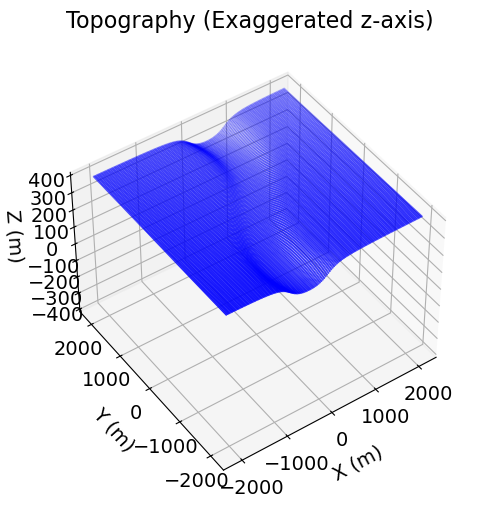

In [4]:
# Plot the topography
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection="3d")
ax.set_zlim([-400, 400])
ax.scatter3D(topo_xyz[:, 0], topo_xyz[:, 1], topo_xyz[:, 2], s=0.25, c="b")
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel("X (m)", labelpad=10)
ax.set_ylabel("Y (m)", labelpad=10)
ax.set_zlabel("Z (m)", labelpad=10)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=-20)
ax.view_init(elev=45.0, azim=-125)

## Define the IP Survey

A full description of elements required to define DC and IP surveys was presented in the [3D Forward Simulation of DC Resistivity Data](../05-dcr/fwd_dcr_3d.ipynb) tutorial. Here, we take the same approach. The only difference is that our receivers are defined to measure apparent chargeabilities. Because SimPEG uses a linearized formulation for simulating IP data; see [Simulation3DCellCentered](myst:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation3DCellCentered) or [Simulation3DNodal](myst:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation3DNodal), the units of the apparent chargeability data are the same as the units chosen to represent the subsurface chargeabilities..

Here, the survey consists of 5 IP lines that use a dipole-dipole electrode configuration; 1 line along the East-West direction and 2 lines along the North-South direction. Each line is 2000 m in length and has an electrode spacing of 100 m.

In [5]:
# Define the parameters for each survey line
survey_type = "dipole-dipole"
dimension_type = "3D"
data_type = "apparent_chargeability"
end_locations_list = [
    np.r_[-1000.0, 1000.0, 0.0, 0.0],
    np.r_[-600.0, -600.0, -1000.0, 1000.0],
    np.r_[-300.0, -300.0, -1000.0, 1000.0],
    np.r_[0.0, 0.0, -1000.0, 1000.0],
    np.r_[300.0, 300.0, -1000.0, 1000.0],
    np.r_[600.0, 600.0, -1000.0, 1000.0],
]
station_separation = 100.0
num_rx_per_src = 8

In [6]:
ip_source_list = []
for ii in range(0, len(end_locations_list)):
    ip_source_list += generate_dcip_sources_line(
        survey_type,
        "apparent_chargeability",
        dimension_type,
        end_locations_list[ii],
        topo_xyz,
        num_rx_per_src,
        station_separation,
    )

# Define the survey
survey = ip.survey.Survey(ip_source_list)

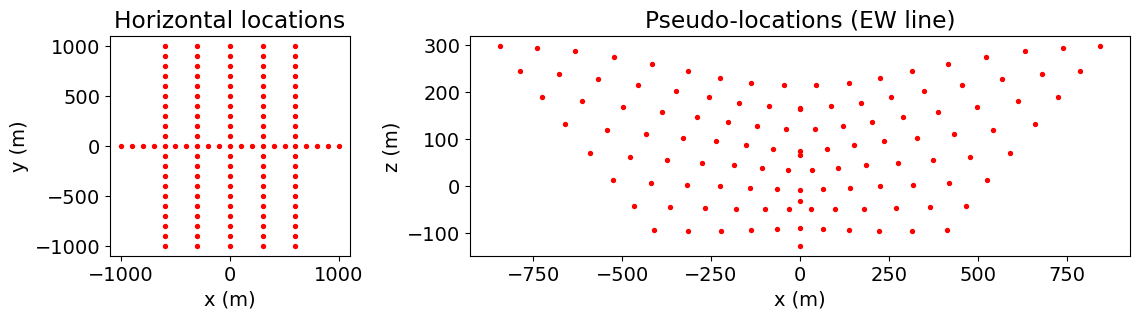

In [7]:
unique_locations = survey.unique_electrode_locations
fig = plt.figure(figsize=(12, 2.75))
ax1 = fig.add_axes([0.1, 0.1, 0.2, 0.8])
ax1.scatter(unique_locations[:, 0], unique_locations[:, 1], 8, "r")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")
ax1.set_title("Horizontal locations")

pseudo_locations = pseudo_locations(survey)
inds = (pseudo_locations[:, 1] == 0.0) & (np.abs(pseudo_locations[:, 0]) != 350)
ax2 = fig.add_axes([0.4, 0.1, 0.55, 0.8])
ax2.scatter(pseudo_locations[inds, 0], pseudo_locations[inds, -1], 8, "r")
ax2.set_xlabel("x (m)")
ax2.set_ylabel("z (m)")
ax2.set_title("Pseudo-locations (EW line)")
plt.show()

## Design a (Tree) Mesh

Here, we generate a tree mesh based on the survey geometry. We use the same mesh that was generated for the [3D Forward Simulation of DC Resistivity Data](../05-dcr/fwd_dcr_3d.ipynb) tutorial. The best-practices for generating meshes for DC/IP simulations is presented in the [2.5D Forward Simulation of DC Resistivity Data](../05-dcr/fwd_dcr_2d.ipynb) tutorial.

In [8]:
# Defining domain size and minimum cell size
dh = 25.0  # base cell width
dom_width_x = 8000.0  # domain width x
dom_width_y = 8000.0  # domain width y
dom_width_z = 4000.0  # domain width z

# Number of base mesh cells in each direction. Must be a power of 2
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcy = 2 ** int(np.round(np.log(dom_width_y / dh) / np.log(2.0)))  # num. base cells y
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hy = [(dh, nbcy)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hy, hz], x0="CCN")

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0.0, 0.0, z_topo.max()]

# Mesh refinement based on surface topography
k = np.sqrt(np.sum(topo_xyz[:, 0:2] ** 2, axis=1)) < 1200
mesh.refine_surface(topo_xyz[k, :], padding_cells_by_level=[0, 4, 4], finalize=False)

# Mesh refinement near electrodes.
mesh.refine_points(unique_locations, padding_cells_by_level=[6, 6, 4], finalize=False)

# Finalize the mesh
mesh.finalize()

## Define the Active Cells

Use the [active_from_xyz](myst:discretize#discretize.utils.active_from_xyz) utility function to obtain the indices of the active mesh cells from topography (e.g. cells below surface).

In [9]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_xyz)

# number of active cells
n_active = np.sum(active_cells)

## Define the Background Conductivity/Resistivity

In order to simulate IP data, we require the background conductivity/resistivity defined on the entire mesh. You can generate this directly, or apply the appropriate mapping to different parameterization of the conductivity/resistivity. Here, we generate the same conuductivity model that was used for the [3D Forward Simulation of DC Resistivity Data](../05-dcr/fwd_dcr_3d.ipynb) tutorial.

In [10]:
# Define electrical conductivities in S/m
air_conductivity = 1e-8
background_conductivity = 1e-2
conductor_conductivity = 1e-1
resistor_conductivity = 1e-3

In [11]:
# Define conductivity model
conductivity_model = background_conductivity * np.ones(n_active)

ind_conductor = model_builder.get_indices_sphere(
    np.r_[-300.0, 0.0, 100.0], 165.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_conductor] = conductor_conductivity

ind_resistor = model_builder.get_indices_sphere(
    np.r_[300.0, 0.0, 100.0], 165.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_resistor] = resistor_conductivity

In [12]:
# Mapping from conductivity to all mesh cells.
conductivity_map = maps.InjectActiveCells(mesh, active_cells, air_conductivity)

In [13]:
# Mapping to neglect air cells when plotting
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

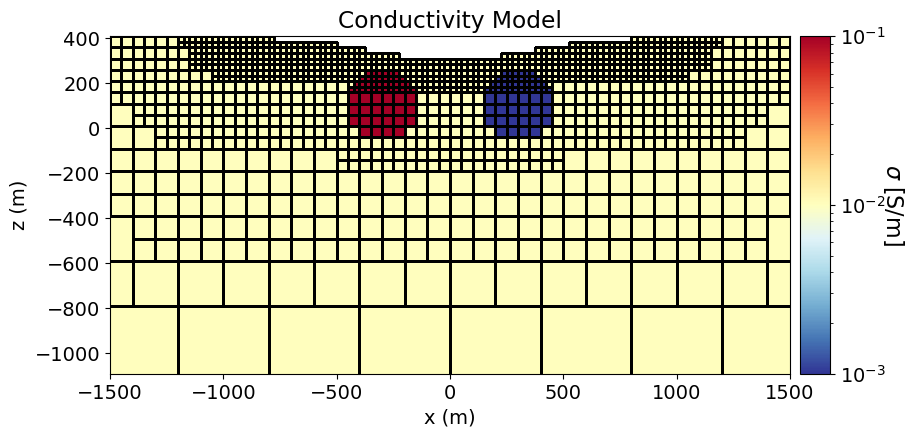

In [14]:
fig = plt.figure(figsize=(10, 4.5))

norm = LogNorm(vmin=1e-3, vmax=1e-1)

ax1 = fig.add_axes([0.15, 0.15, 0.68, 0.75])
mesh.plot_slice(
    plotting_map * conductivity_model,
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_xlim([-1500, 1500])
ax1.set_ylim([z_topo.max() - 1500, z_topo.max()])

ax2 = fig.add_axes([0.84, 0.15, 0.03, 0.75])
cbar = mpl.colorbar.ColorbarBase(
    ax2, cmap=mpl.cm.RdYlBu_r, norm=norm, orientation="vertical"
)
cbar.set_label("$\sigma$ [S/m]", rotation=270, labelpad=15, size=16)

## Define the Chargeability Model and Mapping

The model does not need to be synonymous with the physical property values. But it is common to define chargeability models as the chargeabilities for all subsurface (active) cells. So, what are the units?

SimPEG uses a linearized formulation for simulating IP data; see [Simulation2DCellCentered](myst:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation2DCellCentered) or [Simulation2DNodal](myst:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation2DNodal). In this formulation, any standard definition of the chargeability can be used. And the resulting apparent chargeability data will be in terms of the same units; e.g. intrinsic chargeability (V/V or mV/V) or integrated chargeability (ms). If you are simulating secondary voltages, the chargeability model must represent intrinsic chargeabilities ($0 \leq \eta \leq 1$) in V/V.

For this tutorial, we use the intrinsic chargeability in units V/V. Here, the conductive sphere is chargeable, but the resistive sphere and the host are not. Note that unlike DC resistivity, the physical property value defining air cells for IP simulation can be set to zero.

In [15]:
# Define intrinsic chargeability model (V/V)
air_value = 0.0
background_value = 1e-6
chargeable_value = 0.1

In [16]:
# Define chargeability model
chargeability_model = background_value * np.ones(n_active)

ind_chargeable = model_builder.get_indices_sphere(
    np.r_[-350.0, 0.0, 100.0], 160.0, mesh.cell_centers[active_cells, :]
)

chargeability_model[ind_chargeable] = chargeable_value

In [17]:
# Define mapping from model to mesh cells
chargeability_map = maps.InjectActiveCells(mesh, active_cells, air_value)

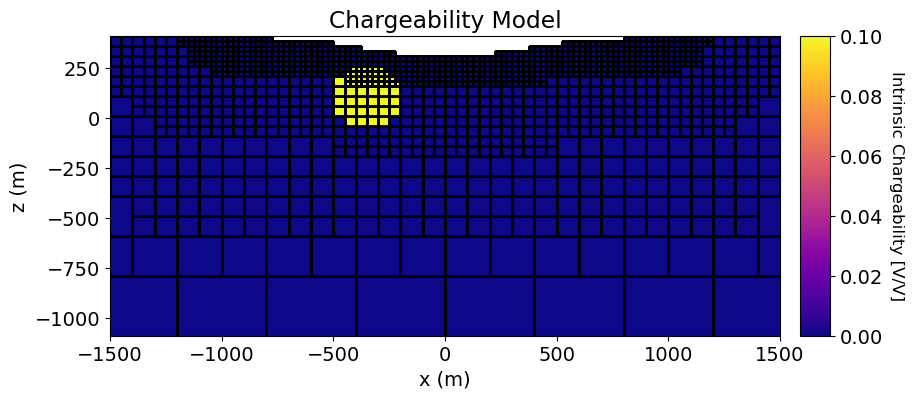

In [18]:
# Plot Chargeability Model
fig = plt.figure(figsize=(10, 4))

norm = Normalize(vmin=0.0, vmax=0.1)

ax1 = fig.add_axes([0.15, 0.15, 0.67, 0.75])
mesh.plot_slice(
    plotting_map * chargeability_model,
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.plasma, "norm": norm},
)
ax1.set_title("Chargeability Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_xlim([-1500, 1500])
ax1.set_ylim([z_topo.max() - 1500, z_topo.max()])

ax2 = fig.add_axes([0.84, 0.15, 0.03, 0.75])
cbar = mpl.colorbar.ColorbarBase(
    ax2, cmap=mpl.cm.plasma, norm=norm, orientation="vertical", format="%.2f"
)
cbar.set_label("Intrinsic Chargeability [V/V]", rotation=270, labelpad=15, size=12)

## Project Electrodes to Discretized Topography

As explained in the [3D Forward Simulation of DC Resistivity Data](../05-dcr/fwd_dcr_3d.ipynb) tutorial, we use the [drape_electrodes_on_topography](myst:simpeg#simpeg.electromagnetics.static.resistivity.Survey.drape_electrodes_on_topography) method to project the electrodes to the discrete surface topography.

In [19]:
survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

## Define the IP Simulation

There are two simulation classes which may be used to simulate 2.5D IP data:

- [Simulation3DNodel](myst:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation3DNodal), which defines the discrete electric potentials on mesh nodes.
- [Simulation3DCellCentered](myst:simpeg#simpeg.electromagnetics.static.induced_polarization.Simulation3DCellCentered), which defines the discrete electric potentials at cell centers.

For surface DC and IP data, the nodal formulation is more well-suited and will be used here. The cell-centered formulation works well for simulating borehole DC and IP data. To fully define the forward simulation, we need to connect the simulation object to:

- the survey
- the mesh
- a background conductivity or resistivity model
- the mapping from the chargeability model to the mesh

If working with electrical conductivity, use the ``sigma`` keyword argument to define the background conductivity on the entire mesh. If working with electrical resistivity, use the ``rho`` keyword argument to define the background resistivity on the entire mesh. The ``etaMap`` is used to define the mapping from the chargeability model to the chargeabilities on the entire mesh.

In [20]:
ip_simulation = ip.Simulation3DNodal(
    mesh,
    survey=survey,
    etaMap=chargeability_map,
    sigma=conductivity_map * conductivity_model,
)

## Simulate IP Data

In [21]:
dpred_ip = ip_simulation.dpred(chargeability_model)

## Plot IP Data in Pseudosection

### Plot 3D Pseudosection

For general 3D survey configurations, we can use the [plot_3d_pseudosection](simpeg#simpeg.electromagnetics.static.utils.plot_3d_pseudosection) utility function to plot 3D pseudosection data. For large datasets or for surveys with unconventional electrode geometry, interpretation can be challenging if we plot every datum. Here, we plot 3 out of the 6 survey lines to better image anomalous structures. To plot ALL of the data, simply remove the keyword argument *plane_points* when calling *plot_3d_pseudosection*. To use this utility, you must have Python's [plotly](https://plotly.com/python/) package.

In [22]:
# Empty list for plane points
plane_points = []

# 3-points defining the plane for EW survey line
p1, p2, p3 = np.array([-1000, 0, 0]), np.array([1000, 0, 0]), np.array([0, 0, -1000])
plane_points.append([p1, p2, p3])

# NS at x = -300 m
p1, p2, p3 = (
    np.array([-300, -1000, 0]),
    np.array([-300, 1000, 0]),
    np.array([-300, 0, -1000]),
)
plane_points.append([p1, p2, p3])

# NS at x = 300 m
p1, p2, p3 = (
    np.array([300, -1000, 0]),
    np.array([300, 1000, 0]),
    np.array([300, 0, -1000]),
)
plane_points.append([p1, p2, p3])

In [23]:
if has_plotly:
    fig = plot_3d_pseudosection(
        survey,
        dpred_ip,
        vlim=[0.0, np.max(dpred_ip)],
        scale="linear",
        units="V/V",
        plane_points=plane_points,
        plane_distance=15,
        marker_opts={"colorscale": "plasma"},
    )

    fig.update_layout(
        title_text="Apparent Chargeability",
        title_x=0.5,
        title_font_size=24,
        width=650,
        height=500,
        scene_camera=dict(center=dict(x=0.05, y=0, z=-0.4)),
    )

    #     plotly.io.show(fig)
    html_str = plotly.io.to_html(fig)
    display(HTML(html_str))

else:
    print("INSTALL 'PLOTLY' TO VISUALIZE 3D PSEUDOSECTIONS")

INSTALL 'PLOTLY' TO VISUALIZE 3D PSEUDOSECTIONS


### Plot Individual Lines in 2D Pseudosection

For conventional DC resistivity surveys, the electrodes are located along a set of survey lines. If we know which the survey line associated with each datum, we can parse the 3D survey into a set of 2D survey lines. Then we can plot individual pseudosections for each survey line. This was detailed in the [3D Forward Simulation of DC Resistivity Data](../05-dcr/fwd_dcr_3d.ipynb) tutorial. Here, we have 6 survey lines, each of which has the same number of data. So assigning a line ID to each datum is easy. You may need to do something more sophisticated in other cases.

In [24]:
# Define the line IDs for all data
n_lines = len(end_locations_list)
n_data_per_line = int(survey.nD / n_lines)
lineID = np.hstack([(ii + 1) * np.ones(n_data_per_line) for ii in range(n_lines)])

Here, we use the [convert_survey_3d_to_2d_lines](simpeg#simpeg.electromagnetics.static.utils.convert_survey_3d_to_2d_lines) to generate the list of 2D surveys.

In [25]:
survey_2d_list, index_list = convert_survey_3d_to_2d_lines(
    survey, lineID, data_type="apparent_chargeability", output_indexing=True
)

Next, we create list of 2D apparent chargeabilities.

In [26]:
dobs_2d_list = []
apparent_chargeability_2d = []
for ind in index_list:
    dobs_2d_list.append(dpred_ip[ind])
    apparent_chargeability_2d.append(dpred_ip[ind])

Now we can use the [plot_2d_pseudosection](simpeg#simpeg.electromagnetics.static.utils.plot_2d_pseudosection) utility function to plot the pseudosection for the desired survey line.

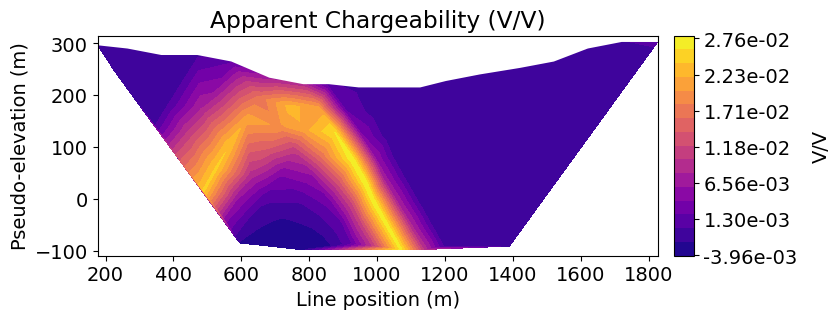

In [27]:
line_index = 0

fig = plt.figure(figsize=(8, 2.75))

ax1 = fig.add_axes([0.1, 0.1, 0.7, 0.8])
cax1 = fig.add_axes([0.82, 0.1, 0.025, 0.8])
plot_pseudosection(
    survey_2d_list[line_index],
    apparent_chargeability_2d[line_index],
    "contourf",
    ax=ax1,
    cax=cax1,
    scale="linear",
    cbar_label="V/V",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.plasma},
)
ax1.set_title("Apparent Chargeability (V/V)")

plt.show()

**Optional:** Write data and topography

In [28]:
if write_output:
    dir_path = os.path.sep.join([".", "fwd_ip_3d_outputs"]) + os.path.sep
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    # Add 10% Gaussian noise to each datum
    np.random.seed(433)
    std = 5e-3 * np.ones_like(dpred_ip)
    noise = std * np.random.normal(size=len(dpred_ip))
    dobs = dpred_ip + noise

    # Create dictionary that stores line IDs
    out_dict = {"LINEID": lineID}

    # Create a survey with the original electrode locations
    # and not the shifted ones
    source_list = []
    for ii in range(0, len(end_locations_list)):
        source_list += generate_dcip_sources_line(
            survey_type,
            data_type,
            dimension_type,
            end_locations_list[ii],
            topo_xyz,
            num_rx_per_src,
            station_separation,
        )
    survey_original = ip.survey.Survey(source_list)

    # Write out data at their original electrode locations (not shifted)
    data_obj = data.Data(survey_original, dobs=dobs, standard_deviation=std)

    fname = dir_path + "ip_data.xyz"
    write_dcip_xyz(
        fname,
        data_obj,
        data_header="APP_CHG",
        uncertainties_header="UNCERT",
        out_dict=out_dict,
    )

    fname = dir_path + "topo_xyz.txt"
    np.savetxt(fname, topo_xyz, fmt="%.4e")